# Importing the essential libraries

In [1]:
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
from collections import Counter
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from scipy.sparse import csr_matrix, coo_matrix
from imblearn.over_sampling import SMOTENC

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


Bad key "text.kerning_factor" on line 4 in
C:\Users\desh669\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
C:\Users\desh669\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\desh669\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version

# Setting the working Directory

In [2]:
cd C:\Users\desh669\OneDrive - PNNL\Desktop\Analytics_2

C:\Users\desh669\OneDrive - PNNL\Desktop\Analytics_2


# Loading json file in a dictionary format

In [3]:
with open("dict_train.json", "r") as read_file:
    data = json.load(read_file)

In [4]:
### Printing names of keys and number of values each key contain
for key, value in data.items():
    print(key,len(value))

data 6317199
row_index 6317199
column_index 6317199
schema 106428
shape 2
labels 12536


In [5]:
### Finding number of occurences of each label in our data 
Counter(data['labels'])
### Looks like the data is imbalanced

Counter({1: 1883, 0: 8678, 2: 771, 4: 512, 3: 692})

# Visualizing Data Imbalance

Text(0.5, 1.0, 'Severity of Attacks \n (0 : least severe & 4 : Most severe)')

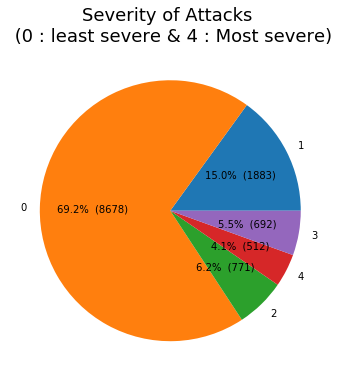

In [6]:
### Now we will try to see this result graphically
### pie chart of imbalanced data
fig = plt.figure(figsize=(16,6))

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

#plt.pie(values, labels=labels, autopct=make_autopct(values))
plt.pie([float(v) for v in Counter(data['labels']).values()], labels=[int(k) for k in Counter(data['labels'])],
           autopct=make_autopct([float(v) for v in Counter(data['labels']).values()]))
plt.title('Severity of Attacks \n (0 : least severe & 4 : Most severe)',fontsize = 18)
#plt.savefig('Piechart.png')

In [7]:
### Taking all the schemas in a list
list_schema = [v for k,v in data.items() if k=='schema']

In [8]:
### Flatenning the list
flat_schema = []
for i in range(106428):
    flat_schema.append(list_schema[0][i])
print(len(flat_schema))

106428


In [9]:
Counter([flat_schema[i].count(' ') for i in range(len(flat_schema))])

Counter({0: 1111, 1: 28000, 2: 77317})

In [10]:
main_effects,second_order_effects,third_order_effects = [],[],[]
for i in flat_schema:
    if i.count(' ') == 0:
        main_effects.append(i)
    if i.count(' ') == 1:
        second_order_effects.append(i)
    if i.count(' ') == 2:
        third_order_effects.append(i)
print(len(main_effects))
print(len(second_order_effects))
print(len(third_order_effects))

1111
28000
77317


In [11]:
### Counting freq of every number present in our data
distribution = Counter(data['data'])
# distribution

# Visualizing the frequnecy using Histograms

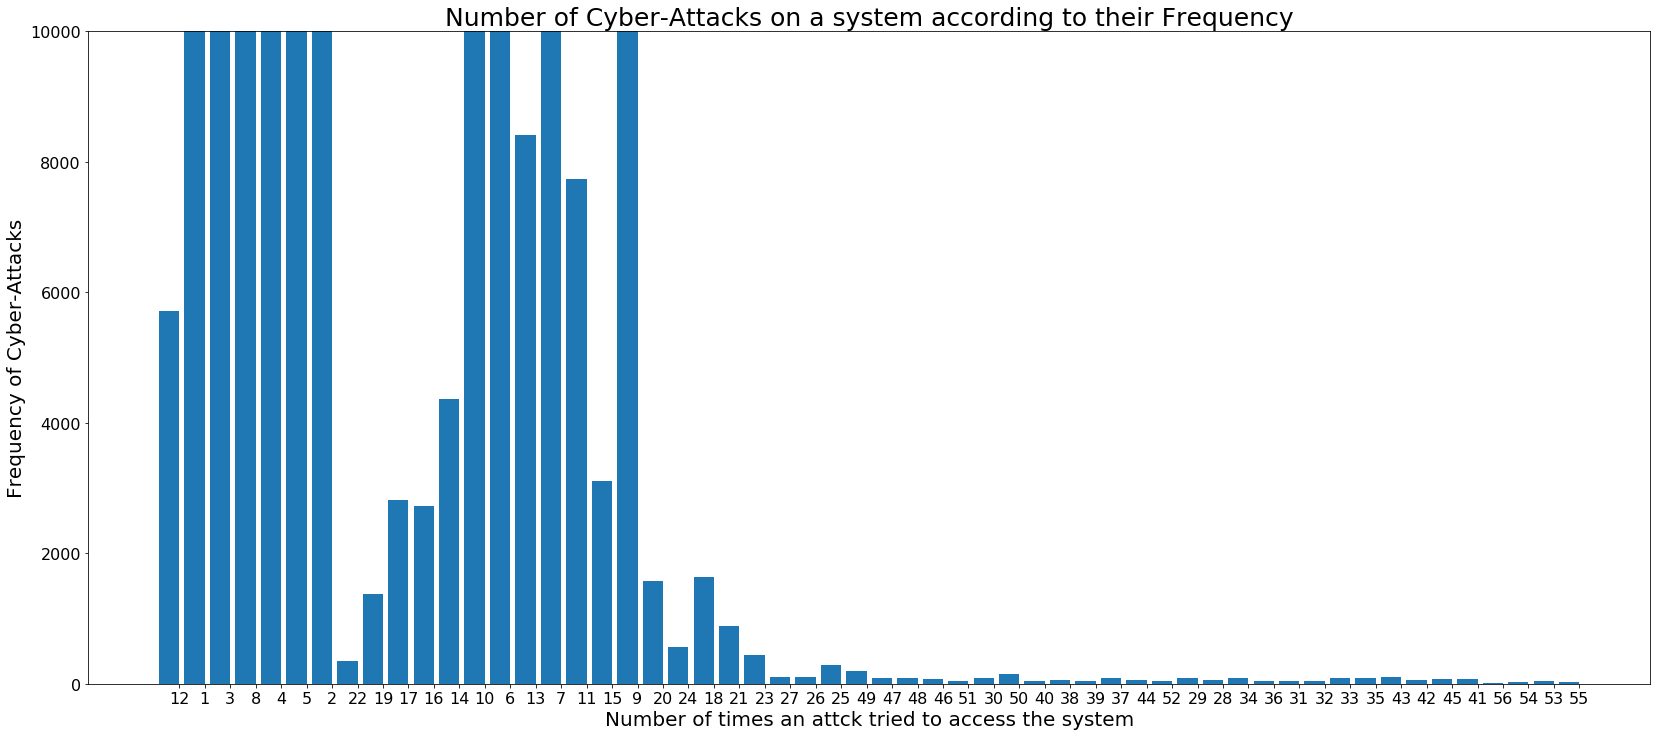

In [12]:
fig = plt.figure(figsize=(28,12))
labels, values = zip(*Counter(data['data']).items())

indexes = np.arange(len(labels))
width = 0.8
# print(indexes)
# print(values)
plt.bar(indexes, values, width)
plt.ylim(0,10000)
plt.xticks(indexes + width * 0.5, labels,fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Number of Cyber-Attacks on a system according to their Frequency',fontsize = 25)
plt.xlabel('Number of times an attck tried to access the system',fontsize = 20)
plt.ylabel('Frequency of Cyber-Attacks',fontsize = 20)
#plt.savefig('Distribution_of_attacks.png')
plt.show()

In [13]:
### Creating an empty dataframe for populating 
###########################################
# df = pd.DataFrame(data = 0,index=set(data['row_index']),columns=data['schema'],dtype = 'float16' )
# print(df.shape)
# df.head()

In [14]:
### Slower way of making a dataframe from a dictionary (Json)
###########################################################
# for i,j,k in zip(data['row_index'],data['column_index'],data['data']):
    
#     #print(i,j,k)
#     df.loc[i][j] = k
#     #break

In [15]:
#### Number of unique values in our data
len(set(k for k in data['data']))
### There are 56 unique values in our dataset

56

# Making a dictionary with key as (row_index,column_index) and value as data. (To Convert it later into a sprse matrix)

In [16]:
import tqdm
my_dict = {}
for i,j,k in tqdm.tqdm(zip(data['row_index'],data['column_index'],data['data'])):
    my_dict[(i,j)] = k
    #print(my_dict)

6317199it [00:09, 641206.33it/s]


In [17]:
### This is for creating a sparse matrix from a dictionary created above

def convert(term_dict):
    # Create the appropriate format for the COO format.
    data = []
    row = []
    col = []
    
    ## Now let us iterate through our dictionary.
    for k, v in term_dict.items():
        r = int(k[0])
        c = int(k[1])
        data.append(v)
        row.append(r)
        col.append(c)
    
    #print(len(data))
    #print(len(row))
    #print(len(col))
    # Create the COO-matrix
    coo = coo_matrix((data,(row,col)))
    
    # Let Scipy convert COO to CSR format and return
    return csr_matrix(coo)

In [18]:
matrix = convert(my_dict)
### Let us check no of rows and col in our matrix
print(matrix.shape)
type(matrix)
### There are in total 12536 rows and 106428 columns in our sparse matrix

(12536, 106428)


scipy.sparse.csr.csr_matrix

In [19]:
### This can be used to conver sparse matrix to dataframe (Consumes 5 GB of Memory)
#df = pd.DataFrame(matrix.toarray())

In [20]:
### To check no of stored elements in ith column
matrix[:,-1]

<12536x1 sparse matrix of type '<class 'numpy.intc'>'
	with 3 stored elements in Compressed Sparse Row format>

In [21]:
### To get sum across columns
a = matrix.sum(axis=1)

In [22]:
### Find out which columns to keep 
# all_col_index = list(set(list(data['column_index'])))
# len(all_col_index)

In [23]:
### This function returns the missing elements in a sequence
# def missing_elements(L):
#     start, end = L[0], L[-1]
#     return sorted(set(range(start, end + 1)).difference(L))

In [24]:
### Returns the absent column index
# len(missing_elements(all_col_index))

# This creates a new sparse matrix with non empty columns only (Avoiding this step for now)

In [25]:
# x_new = sparse.lil_matrix(sparse.csr_matrix(matrix)[:,all_col_index])

# print(type(x_new))
# x_new.shape

# This normalizes the sparse matrix and stores it as a new sparse matrix

In [26]:
from sklearn.preprocessing import normalize
w_normalized = normalize(matrix, norm='l1', axis=1)
w_normalized.shape

(12536, 106428)

# Handling Data Imbalance Method 1 - OverSampling

In [27]:
smote_nc = SMOTE(random_state=2)
X_resampled, y_resampled = smote_nc.fit_resample(w_normalized, data['labels'])
print(sorted(Counter(y_resampled).items()))

C:\Users\desh669\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[(0, 8678), (1, 8678), (2, 8678), (3, 8678), (4, 8678)]


# Spliting the balanced and Normalized data into training and testing

In [28]:
train_x, test_x, train_labels, test_labels = train_test_split(X_resampled,y_resampled,
                                                              test_size=0.3, 
                                                              random_state=123)

In [29]:
### getting the splits into the proper formats
test_labels = np.reshape(np.array(test_labels),(-1,1))
train_labels = np.reshape(np.array(train_labels),(-1,1))
print(test_labels.shape)
print(train_labels.shape)

(13017, 1)
(30373, 1)


In [30]:
#### This can be used to rescale the dataframe.

# scaler = StandardScaler()
# # Fit on training set only.

# scaler.fit(train_x)
# # Apply transform to both the training set and the test set.
# train_x = scaler.transform(train_x)
# test_x = scaler.transform(test_x)

# Model 1 - Logistic Regression - Over Sampling

In [31]:
model = LogisticRegression(solver = 'newton-cg')
model.fit(train_x,train_labels)

# use the model to make predictions with the test data
y_pred_Logistic = model.predict(test_x)
# how did our model perform?
#count_misclassified = (test_labels != y_pred).sum()
#print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(test_labels, y_pred_Logistic)
print('Accuracy: {:.2f}'.format(accuracy))

C:\Users\desh669\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.72


In [32]:
from sklearn.metrics import confusion_matrix
#y_actu = [2, 0, 2, 2, 0, 1, 1, 2, 2, 0, 1, 2]
#y_pred = [0, 0, 2, 1, 0, 2, 1, 0, 2, 0, 2, 2]
confusion_matrix(test_labels, y_pred_Logistic)

array([[1303,   17,  185,  420,  576],
       [  26, 2225,    6,   92,  232],
       [ 284,    0, 1892,  119,  350],
       [  76,    2,  102, 1971,  516],
       [  99,   57,   68,  459, 1940]], dtype=int64)

# Model2  Decision Tree Classification - Over Sampling

In [33]:
from sklearn.tree import DecisionTreeClassifier

# Make a decision tree and train
tree = DecisionTreeClassifier(random_state=223)
tree.fit(train_x,train_labels)
y_pred_Decision = tree.predict(test_x)
# how did our model perform?
#count_misclassified = (test_labels != y_pred).sum()
#print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(test_labels, y_pred_Decision)
print('Accuracy: {:.2f}'.format(accuracy))

Accuracy: 0.96


In [34]:
### Decision Trees 
from sklearn.metrics import confusion_matrix
#y_actu = [2, 0, 2, 2, 0, 1, 1, 2, 2, 0, 1, 2]
#y_pred = [0, 0, 2, 1, 0, 2, 1, 0, 2, 0, 2, 2]
confusion_matrix(test_labels, y_pred_Decision)

array([[2269,   14,   76,   91,   51],
       [  13, 2563,    0,    0,    5],
       [  63,    2, 2556,   14,   10],
       [  61,    0,    5, 2588,   13],
       [  38,    4,   13,   15, 2553]], dtype=int64)

# Handling Data Imbalance Method 2 - UnderSampling

In [35]:
undersampling = RandomUnderSampler(random_state=2)
X_resampled, y_resampled = undersampling.fit_resample(w_normalized, data['labels'])
print(sorted(Counter(y_resampled).items()))

C:\Users\desh669\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[(0, 512), (1, 512), (2, 512), (3, 512), (4, 512)]


In [36]:
train_x, test_x, train_labels, test_labels = train_test_split(X_resampled,y_resampled,
                                                              test_size=0.3, 
                                                              random_state=123)
### getting the splits into the proper formats
test_labels = np.reshape(np.array(test_labels),(-1,1))
train_labels = np.reshape(np.array(train_labels),(-1,1))
print(test_labels.shape)
print(train_labels.shape)

(768, 1)
(1792, 1)


# Model 1 Logistic Regression - UnderSampling

In [37]:
model = LogisticRegression(solver = 'newton-cg')
model.fit(train_x,train_labels)

# use the model to make predictions with the test data
y_pred_Logistic = model.predict(test_x)
# how did our model perform?
#count_misclassified = (test_labels != y_pred).sum()
#print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(test_labels, y_pred_Logistic)
print('Accuracy: {:.2f}'.format(accuracy))

#y_actu = [2, 0, 2, 2, 0, 1, 1, 2, 2, 0, 1, 2]
#y_pred = [0, 0, 2, 1, 0, 2, 1, 0, 2, 0, 2, 2]
confusion_matrix(test_labels, y_pred_Logistic)

C:\Users\desh669\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.55


array([[ 73,  16,  23,   0,  26],
       [  8, 128,   1,   0,  14],
       [ 17,   3, 122,   0,  17],
       [ 54,  44,  18,   8,  37],
       [ 25,  31,  10,   1,  92]], dtype=int64)

# Model 2 Decision Tree Classification - Under Sampling

In [38]:
# Make a decision tree and train
tree = DecisionTreeClassifier(random_state=223)
tree.fit(train_x,train_labels)
y_pred_Decision = tree.predict(test_x)
# how did our model perform?
#count_misclassified = (test_labels != y_pred).sum()
#print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(test_labels, y_pred_Decision)
print('Accuracy: {:.2f}'.format(accuracy))

### Decision Trees 
from sklearn.metrics import confusion_matrix
#y_actu = [2, 0, 2, 2, 0, 1, 1, 2, 2, 0, 1, 2]
#y_pred = [0, 0, 2, 1, 0, 2, 1, 0, 2, 0, 2, 2]
confusion_matrix(test_labels, y_pred_Decision)

Accuracy: 0.80


array([[ 97,   1,  18,  11,  11],
       [  3, 146,   0,   1,   1],
       [ 15,   1, 134,   6,   3],
       [ 15,   2,   5, 125,  14],
       [ 12,   0,   7,  27, 113]], dtype=int64)

In [39]:
### Adding labels column to our sparse matrix.
# Data = sparse.hstack((x_new,np.array(data['labels'])[:,None])).A
# Data.shape

In [40]:
#Data[:,-1]

# Predictions on Unseen Dataset

In [41]:
with open("test_data.json", "r") as read_file:
    test_data = json.load(read_file)

for key, value in test_data.items():
    print(key,len(value))

data 1744196
row_index 1744196
column_index 1744196
schema 106428
shape 2


In [42]:
len(list(set(list(test_data['row_index']))))

3133

In [43]:
my_test_dict = {}
for i,j,k in tqdm.tqdm(zip(test_data['row_index'],test_data['column_index'],test_data['data'])):
    my_test_dict[(i,j)] = k
    #print(my_dict)

1744196it [00:02, 643580.33it/s]


In [44]:
test_matrix = convert(my_test_dict)
### Let us check no of rows and col in our matrix
print(test_matrix.shape)
type(test_matrix)
### There are in total 12536 rows and 106428 columns in our sparse matrix

(3133, 106428)


scipy.sparse.csr.csr_matrix

In [45]:
from sklearn.preprocessing import normalize
w_normalized_test = normalize(test_matrix, norm='l1', axis=1)
w_normalized_test.shape

(3133, 106428)

In [46]:
w_normalized_test.shape

(3133, 106428)

In [47]:
w_normalized.shape

(12536, 106428)

In [48]:
smote_nc = SMOTE(random_state=2)
X_resampled, y_resampled = smote_nc.fit_resample(w_normalized, data['labels'])
print(sorted(Counter(y_resampled).items()))

C:\Users\desh669\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[(0, 8678), (1, 8678), (2, 8678), (3, 8678), (4, 8678)]


In [49]:
from sklearn.tree import DecisionTreeClassifier

# Make a decision tree and train
tree = DecisionTreeClassifier(random_state=223)
tree.fit(X_resampled,y_resampled)
y_pred_Decision_test = tree.predict(w_normalized_test)

In [50]:
y_pred_Decision_test.shape

(3133,)

In [51]:
#np.savetxt("predictions1.csv", y_pred_Decision_test, delimiter=",")